In [1]:
from enum import Enum
import torch
import logging
import tqdm
import json
import os
import numpy as np
from dataset import RadarDataset
from model import UNet
from loss import cross_entropy_loss
from torch.utils.data import DataLoader
import torch.nn as nn
from runner import load_checkpoint, save_checkpoint, OptimizerChoice
from train import create_optimizer
from dotenv import load_dotenv
from common import get_scene
from encoder import Grid
import matplotlib.pyplot as plt
from config import label_to_index, CAR, DONT_CARE, final_labels, N_LABELS, label_to_str
from torchmetrics import ConfusionMatrix

load_dotenv()

%load_ext autoreload
%autoreload 2

In [ ]:
def plot_grid(ax, grid: Grid, grid_value: np.ndarray, alpha: float = 0.5, size: int = 5, marker: str = 's'):
    for label in final_labels:
        label_idx = label_to_index[label]
        mask = grid_value == label_idx
        if label == DONT_CARE or not np.any(mask):
            continue
        x_inds, y_inds = np.where(mask)
        x_pos = x_inds * grid.cell_size + grid.x_lims[0]
        y_pos = y_inds * grid.cell_size + grid.y_lims[0]
        ax.scatter(y_pos, x_pos, alpha=alpha, marker=marker, label=label_to_str[label], s=size)

In [25]:
# loading scene
sequence_id = "sequence_1"
data_folder = "train"
exp_name = "baseline_unet_noWCE_ep12"
scene_fn = os.path.join(os.getenv("DATA_LOCATION"), sequence_id, "scenes.json")
detections = get_scene(scene_fn)
tss = detections['timestamp'].unique()
print(detections['label_id'].value_counts())

# loading model for inference
chs = [16, 32, 64]
optimizer_choice = OptimizerChoice.ADAMW
model = UNet(chs=chs, n_classes=N_LABELS)
model.eval() # set model to evaluation mode, no training in inference
optimizer = create_optimizer(model, optimizer_choice, lr=1e-4)
model, optimizer, epoch = load_checkpoint(model, optimizer, f"checkpoints/{exp_name}.pth")

label_id
11    125516
0       5462
1        443
7         71
Name: count, dtype: int64


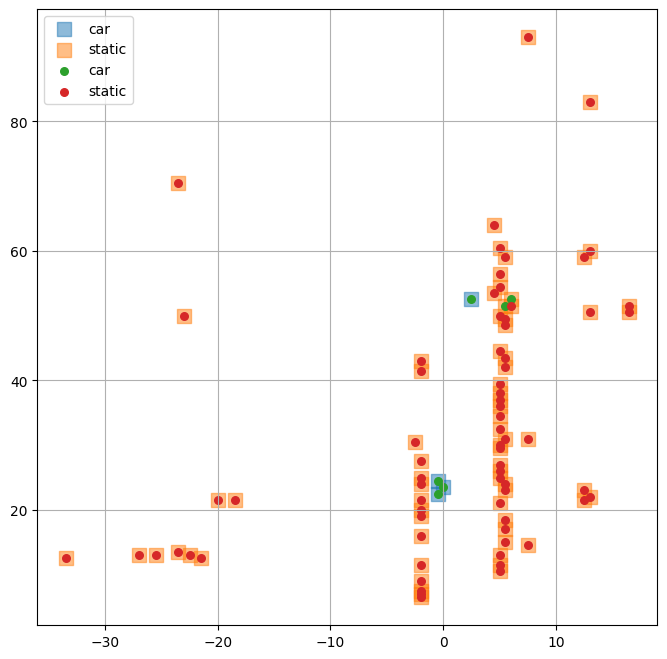

In [44]:
timestamp = tss[200]
cur_dets = detections[detections["timestamp"] == timestamp]

# load pre-made grid
in_grid = torch.load(os.path.join(f"data/{data_folder}/input", f"{sequence_id}_ts{timestamp}_fl.pt"))
out_grid = torch.load(os.path.join(f"data/{data_folder}/gt", f"{sequence_id}_ts{timestamp}_fl.pt"))
grid = Grid.from_existing(in_grid.numpy().transpose(1, 2, 0), out_grid.numpy().transpose(1, 2, 0), x_lims=(2, 100), y_lims=(-50, 20), cell_size=0.5)

# pass grid through model
with torch.no_grad():
    output = model(in_grid.unsqueeze(0))
    
predicted_classes = torch.argmax(output, dim=1).cpu().numpy().squeeze()
out_grid = out_grid.cpu().numpy().squeeze()
predicted_classes[out_grid == label_to_index[DONT_CARE]] = label_to_index[DONT_CARE]

_, _, x_pos, y_pos = grid.get_active_cells_positions()
fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(cur_dets['y_cc'], cur_dets['x_cc'], c=cur_dets['label_id'], s=10)
plot_grid(ax, grid, out_grid, alpha=0.5, size=100)
plot_grid(ax, grid, predicted_classes, alpha=1, size=30, marker='o')
ax.grid()
ax.legend()